In [1]:
# Importing necessary libraries

import os  # Provides functions for interacting with the operating system, used for directory and file handling
import glob  # Used for retrieving file paths matching a specified pattern
import cv2 as cv  # OpenCV library for computer vision tasks like image processing
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices, along with mathematical operations
import pandas as pd  # Data manipulation and analysis library, mainly for working with structured data (e.g., CSV files)
import seaborn as sns  # Data visualization library based on matplotlib, used for drawing attractive and informative statistical graphics
import tensorflow as tf  # Popular deep learning library, used to build and train machine learning models
import matplotlib.pyplot as plt  # Plotting library used for creating static, animated, and interactive visualizations
from sklearn.utils import shuffle  # Utility function to shuffle arrays or sparse matrices
from sklearn.model_selection import train_test_split  # Used to split arrays or matrices into random train and test subsets
from sklearn.metrics import confusion_matrix, classification_report  # Functions for evaluating the performance of classification models

### load data

In [2]:
def load_data():
    # Loads and augments the training and validation data from the 'dataset' directory.
    # Applies several data augmentation techniques such as rescaling, zooming, rotation, and flipping.
    
    # ImageDataGenerator allows for data augmentation to improve model generalization.
    data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,  # Rescale pixel values to the range [0, 1]
        zoom_range=0.2,  # Random zoom within 20%
        rotation_range=45,  # Random rotation within 45 degrees
        vertical_flip=True,  # Random vertical flipping
        horizontal_flip=True,  # Random horizontal flipping
        validation_split=0.15  # Reserve 15% of the data for validation
    )

    # Load and augment the training data subset from the 'dataset' directory.
    train_data = data_generator.flow_from_directory(
        'dataset',  # Path to the dataset directory
        batch_size=32,  # Number of images per batch
        color_mode='rgb',  # Load the images in RGB format
        target_size=(128, 128),  # Resize images to 128x128
        class_mode='binary',  # Expect binary classification (two classes)
        subset='training'  # Use the training split of the data
    )

    # Load and augment the validation data subset.
    val_data = data_generator.flow_from_directory(
        'dataset',  # Path to the dataset directory
        batch_size=32,  # Number of images per batch
        color_mode='rgb',  # Load the images in RGB format
        target_size=(128, 128),  # Resize images to 128x128
        class_mode='binary',  # Expect binary classification
        subset='validation'  # Use the validation split of the data
    )

    return train_data, val_data  # Return the training and validation data generators

def load_eval_data():
    # Loads the entire dataset for evaluation without data augmentation, but rescaling is applied.
    
    # ImageDataGenerator with only rescaling applied (no augmentation).
    data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    # Load the evaluation data from the 'dataset' directory without shuffling.
    eval_data = data_generator.flow_from_directory(
        'dataset',  # Path to the dataset directory
        batch_size=32,  # Number of images per batch
        color_mode='rgb',  # Load the images in RGB format
        target_size=(128, 128),  # Resize images to 128x128
        class_mode='binary',  # Expect binary classification
        shuffle=False  # Disable shuffling, useful for evaluation or inference
    )
    
    return eval_data  # Return the evaluation data generator


In [3]:
train_data, val_data = load_data()

Found 3259 images belonging to 2 classes.
Found 574 images belonging to 2 classes.


### build model

In [4]:
def build_model(input_shape=(128, 128, 3)):
    # Builds a Sequential Convolutional Neural Network (CNN) model
    
    model = tf.keras.models.Sequential([  # Sequential model allows stacking layers one after the other
        
        # First convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        # Max pooling layer to downsample the feature maps by 2x2
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second convolutional layer with 64 filters and 3x3 kernel, followed by MaxPooling
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Third convolutional layer with 64 filters, followed by MaxPooling
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Fourth convolutional layer with 64 filters, followed by MaxPooling
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Flatten the 3D output into a 1D feature vector
        tf.keras.layers.Flatten(),

        # Fully connected (dense) layer with 64 units and ReLU activation
        tf.keras.layers.Dense(64, activation='relu'),

        # Output layer with a single unit and sigmoid activation for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with Adam optimizer, binary crossentropy loss function for binary classification
    model.compile(
        optimizer='adam',  # Adam optimizer for efficient gradient descent
        loss='binary_crossentropy',  # Loss function for binary classification problems
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),  # Track the model's binary classification accuracy
            tf.keras.metrics.Precision(),  # Precision metric to monitor true positives / (true positives + false positives)
            tf.keras.metrics.Recall(),  # Recall metric to monitor true positives / (true positives + false negatives)
            tf.keras.metrics.AUC()  # Area Under the Curve (AUC) metric for performance assessment
        ]
    )
    
    return model  # Return the constructed and compiled model


In [5]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [6]:
history = model.fit(
                    train_data,# Training data generator
                    epochs=100, batch_size=128,# Number of training epochs
                    validation_data=val_data# Validation data generator
                    )

Epoch 1/100
 28/102 [=======>......................] - ETA: 1:28 - loss: 0.6826 - binary_accuracy: 0.5488 - precision: 0.5926 - recall: 0.3851 - auc: 0.5951

c:\Users\User\.conda\envs\myenv\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


102/102 [==============================] - 133s 1s/step - loss: 0.4662 - binary_accuracy: 0.7702 - precision: 0.7905 - recall: 0.7357 - auc: 0.8665 - val_loss: 0.3295 - val_binary_accuracy: 0.8641 - val_precision: 0.8012 - val_recall: 0.9686 - val_auc: 0.9455
Epoch 2/100
102/102 [==============================] - 87s 853ms/step - loss: 0.2874 - binary_accuracy: 0.8911 - precision: 0.8848 - recall: 0.8994 - auc: 0.9489 - val_loss: 0.2900 - val_binary_accuracy: 0.8955 - val_precision: 0.8492 - val_recall: 0.9617 - val_auc: 0.9574
Epoch 3/100
102/102 [==============================] - 88s 863ms/step - loss: 0.2542 - binary_accuracy: 0.9024 - precision: 0.9090 - recall: 0.8945 - auc: 0.9595 - val_loss: 0.2508 - val_binary_accuracy: 0.8902 - val_precision: 0.9000 - val_recall: 0.8780 - val_auc: 0.9635
Epoch 4/100
102/102 [==============================] - 88s 857ms/step - loss: 0.2585 - binary_accuracy: 0.9046 - precision: 0.9079 - recall: 0.9007 - auc: 0.9577 - val_loss: 0.2779 - val_binar

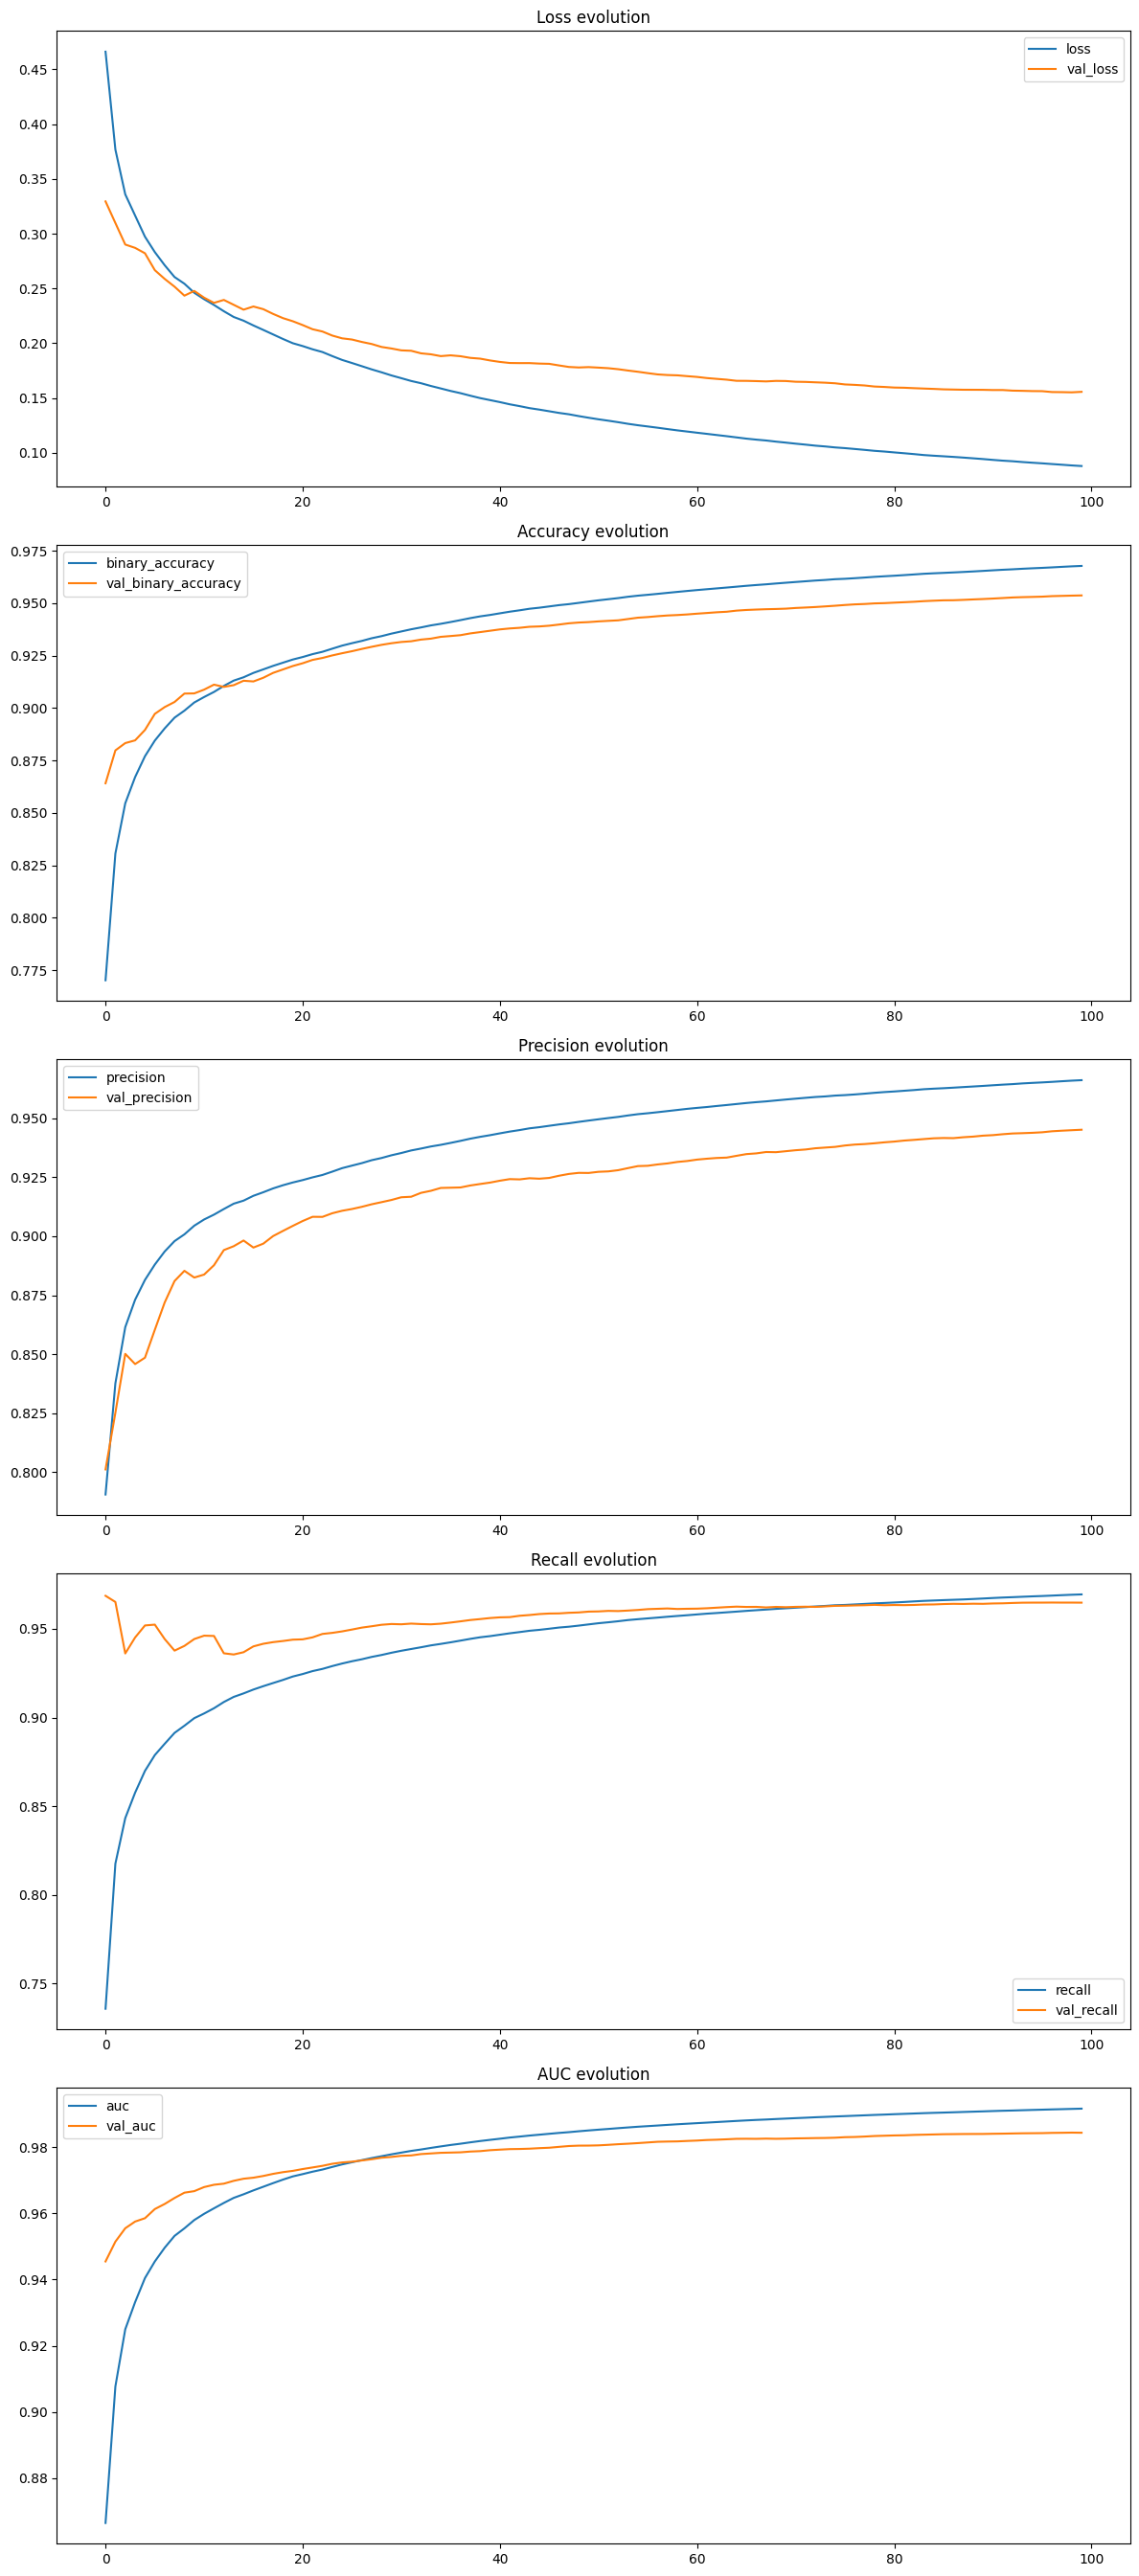

In [7]:


history.history['loss'] = np.cumsum(history.history['loss']) / np.arange(1, len(history.history['loss']) + 1)
history.history['binary_accuracy'] = np.cumsum(history.history['binary_accuracy']) / np.arange(1, len(history.history['binary_accuracy']) + 1)

history.history['val_loss'] = np.cumsum(history.history['val_loss']) / np.arange(1, len(history.history['val_loss']) + 1)
history.history['val_binary_accuracy'] = np.cumsum(history.history['val_binary_accuracy']) / np.arange(1, len(history.history['val_binary_accuracy']) + 1)

history.history['precision'] = np.cumsum(history.history['precision']) / np.arange(1, len(history.history['precision']) + 1)
history.history['recall'] = np.cumsum(history.history['recall']) / np.arange(1, len(history.history['recall']) + 1)

history.history['val_precision'] = np.cumsum(history.history['val_precision']) / np.arange(1, len(history.history['val_precision']) + 1)
history.history['val_recall'] = np.cumsum(history.history['val_recall']) / np.arange(1, len(history.history['val_recall']) + 1)

history.history['auc'] = np.cumsum(history.history['auc']) / np.arange(1, len(history.history['auc']) + 1)
history.history['val_auc'] = np.cumsum(history.history['val_auc']) / np.arange(1, len(history.history['val_auc']) + 1)
# Create a new figure with a size of 12x27 inches for plotting multiple subplots.
plt.figure(figsize=(12, 27))

# Plot the cumulative average of training and validation loss over epochs.
plt.subplot(5, 1, 1)
plt.plot(history.history['loss'], label='loss')  # Training loss
plt.plot(history.history['val_loss'], label='val_loss')  # Validation loss
plt.legend()  # Show legend to differentiate between training and validation data
plt.title('Loss evolution')  # Set the title of the plot

# Plot the cumulative average of training and validation accuracy over epochs.
plt.subplot(5, 1, 2)
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')  # Training accuracy
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')  # Validation accuracy
plt.legend()
plt.title('Accuracy evolution')

# Plot the cumulative average of training and validation precision over epochs.
plt.subplot(5, 1, 3)
plt.plot(history.history['precision'], label='precision')  # Training precision
plt.plot(history.history['val_precision'], label='val_precision')  # Validation precision
plt.legend()
plt.title('Precision evolution')

# Plot the cumulative average of training and validation recall over epochs.
plt.subplot(5, 1, 4)
plt.plot(history.history['recall'], label='recall')  # Training recall
plt.plot(history.history['val_recall'], label='val_recall')  # Validation recall
plt.legend()
plt.title('Recall evolution')

# Plot the cumulative average of training and validation AUC over epochs.
plt.subplot(5, 1, 5)
plt.plot(history.history['auc'], label='auc')  # Training AUC
plt.plot(history.history['val_auc'], label='val_auc')  # Validation AUC
plt.legend()
plt.title('AUC evolution')

# Adjust layout to ensure plots are properly spaced and don't overlap.
plt.tight_layout()

# Display all the plots.
plt.show()


In [8]:
model.save('mask_classification.h5')

### evaluation

In [9]:
# Load the evaluation data using the previously defined function.
eval_data = load_eval_data()

# Extract the true labels (classes) from the evaluation data.
# eval_data.classes returns an array of true class indices for the evaluation dataset.
y_eval = eval_data.classes

# Use the trained model to make predictions on the evaluation data.
# model.predict() generates probabilities for each class for each image.
x_eval = model.predict(eval_data)

# Convert the predicted probabilities to binary class labels.
# np.round() converts probabilities to binary predictions (0 or 1) by rounding to the nearest integer.
# .flatten() reshapes the predictions to a 1D array.
y_pred = np.round(x_eval).flatten()


Found 3833 images belonging to 2 classes.
120/120 [==============================] - 23s 192ms/step


In [10]:
# Generate the classification report
# This function evaluates the performance of the classification model by comparing true labels (y_eval) with predicted labels (y_pred).
# The report includes precision, recall, F1-score, and support for each class.
# `target_names` provides readable class names instead of integer labels.
# `eval_data.class_indices.keys()` returns the class names in the order of their corresponding integer labels, making the report more understandable.
clf = classification_report(y_eval, y_pred, target_names=eval_data.class_indices.keys())

# Print the classification report
# This outputs the classification report to the console, showing the detailed performance metrics for each class.
# It helps to assess how well the model is performing and to identify any areas that might need improvement.
print(clf)

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99      1915
without_mask       0.99      0.99      0.99      1918

    accuracy                           0.99      3833
   macro avg       0.99      0.99      0.99      3833
weighted avg       0.99      0.99      0.99      3833



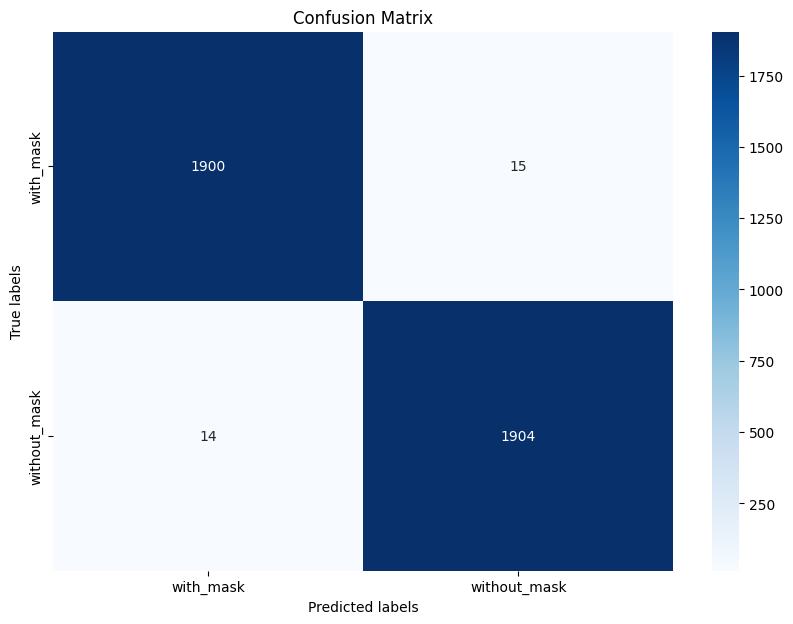

In [11]:
# Compute the confusion matrix
# The confusion matrix compares the true labels (y_eval) with the predicted labels (y_pred).
# It shows how many instances of each class were correctly and incorrectly classified.
cm = confusion_matrix(y_eval, y_pred)

# Convert the confusion matrix into a DataFrame for easier visualization
# `index` and `columns` are set to the class names from `eval_data.class_indices` for readable labels in the heatmap.
df_cm = pd.DataFrame(
    cm, 
    index=eval_data.class_indices.keys(),  # Class names for rows
    columns=eval_data.class_indices.keys()  # Class names for columns
)

# Create a heatmap to visualize the confusion matrix
# The heatmap shows the counts of true vs. predicted labels with annotations.
plt.figure(figsize=(10, 7))  # Set the figure size
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')  # `annot=True` to display values in cells, `fmt='g'` for integer formatting
plt.xlabel('Predicted labels')  # Label for x-axis
plt.ylabel('True labels')  # Label for y-axis
plt.title('Confusion Matrix')  # Title of the heatmap
plt.show()  # Display the plot

In [12]:
# Load the pre-trained model from a saved file
# The model file 'mask_classification.h5' contains the architecture, weights, and training configuration of the model.
model = tf.keras.models.load_model("mask_classification.h5")

# Re-compile the loaded model
# This step is necessary to ensure that the model is configured with the correct optimizer, loss function, and metrics.
# The optimizer, loss function, and metrics should match those used during the model's training.

model.compile(
    optimizer='adam',  # Adam optimizer is used for training. It adapts the learning rate during training.
    loss='binary_crossentropy',  # Binary cross-entropy loss function is used for binary classification problems.
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),  # Metric to track the accuracy of binary classification.
        tf.keras.metrics.Precision(),  # Metric to measure the precision of the model (proportion of true positives over predicted positives).
        tf.keras.metrics.Recall(),  # Metric to measure the recall of the model (proportion of true positives over actual positives).
        tf.keras.metrics.AUC()  # Metric to measure the Area Under the Receiver Operating Characteristic Curve (AUC), assessing the model's ability to distinguish between classes.
    ]
)

In [13]:
def inference_pipeline(
    file_path,
    class_dict = {
        0: 'with_mask',
        1: 'without_mask'
    }
):
    # Read the image from the specified file path
    # cv.imread loads the image from the file, which returns an array of pixel values.
    pixel_array = cv.imread(file_path)
    
    # Convert the image from BGR to RGB color format
    # OpenCV loads images in BGR format by default, so we need to convert it to RGB.
    pixel_array = cv.cvtColor(
        pixel_array, 
        cv.COLOR_BGR2RGB
    )
    
    # Resize the image to the target size expected by the model
    # The model expects images of size (128, 128), so we resize the image to match this size.
    pixel_array = cv.resize(
        pixel_array, 
        (128, 128)
    )
    
    # Add an extra dimension to the image array
    # This is necessary because the model expects a batch of images, so we need to add the batch dimension.
    # The axis=0 argument adds a new dimension at the beginning of the array.
    pixel_array = np.expand_dims(
        pixel_array, 
        axis=0
    )
    
    # Use the model to make a prediction
    # model.predict() returns an array of predicted probabilities. For binary classification, this will be a single value.
    prediction = model.predict(pixel_array)
    
    # Round the prediction to get a binary class label (0 or 1)
    # np.round() converts the predicted probability to a binary class label.
    prediction = np.round(prediction).flatten()[0]
    
    # Map the numeric prediction to the class name using the class_dict
    # class_dict maps the numeric label to the class name.
    prediction = class_dict[prediction]
    
    # Return the predicted class name
    return prediction


1/1 [==============================] - 0s 161ms/step


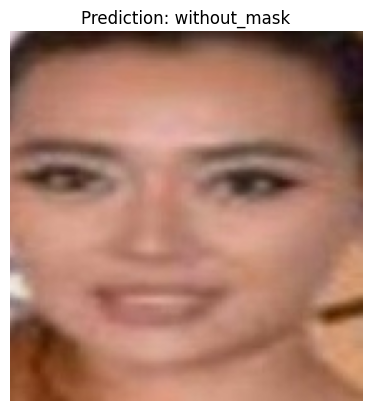

In [14]:
# Define the path to the image file
# You can switch between different image paths to test the pipeline.
image_path = 'dataset/without_mask/0_0_aidai_0014.jpg'
# image_path = 'uploads/5e75e565-1519-4b9c-90a2-f4734af13131.jpg'

# Get the prediction for the image using the inference pipeline
# The `inference_pipeline` function processes the image and returns the predicted class.
prediction = inference_pipeline(image_path)

# Read the image from the file path
# `cv.imread` loads the image from the specified file path into a pixel array.
pixel_array = cv.imread(image_path)

# Convert the image from BGR to RGBA color format
# OpenCV loads images in BGR format by default, and we convert it to RGBA for better display compatibility.
pixel_array = cv.cvtColor(
    pixel_array, 
    cv.COLOR_BGR2RGBA
)

# Display the image with its prediction
# `plt.imshow` shows the image in a plot.
plt.imshow(pixel_array)
plt.axis('off')  # Hide the axis for a cleaner display
plt.title(f'Prediction: {prediction}')  # Set the title of the plot to show the prediction result
plt.show()  # Display the plot
